In [1]:
import json
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from diced import DicedStore

store = DicedStore("gs://flyem-public-connectome")
repo_grayscale = store.open_repo("medulla7column")
repo_groundtruth = store.open_repo("medulla7column")


In [57]:
grayscale = repo_grayscale.get_array("grayscale")
groundtruth = repo_groundtruth.get_array("groundtruth")


In [2]:
# Open roi.json file and specify as a numpy array:

with open('json/roi.json', 'r') as f:
    data = json.load(f)
    
roi_idx = np.array(data)
roi_idx[0:5]


array([[ 53,  77, 101, 149],
       [ 53,  78, 101, 149],
       [ 53,  79, 101, 149],
       [ 53,  80, 101, 149],
       [ 53,  81, 101, 149]])

In [3]:
# Create DataFrame from 'roi_idx':

col_name = ['z_start', 'y_start', 'x0_start', 'x1_start']
df = pd.DataFrame(roi_idx, columns=col_name)
df.head(5)


,z_start,y_start,x0_start,x1_start
0,53,77,101,149
1,53,78,101,149
2,53,79,101,149
3,53,80,101,149
4,53,81,101,149


In [4]:
# Translate to voxel coorinates:

df_coord = df * 32
df_coord.head(5)


,z_start,y_start,x0_start,x1_start
0,1696,2464,3232,4768
1,1696,2496,3232,4768
2,1696,2528,3232,4768
3,1696,2560,3232,4768
4,1696,2592,3232,4768


In [6]:
# Load the synapse.json file:

with open('json/synapse.json', 'r') as f:
    synapse_json = json.load(f)
    
# Get the location of specific 'T-bar': 

data = synapse_json['data'][22]
loc_tbar = data['T-bar']['location']
print("The voxel coordinates of T-bar is [x, y, z] = " + str(loc_tbar))

# Get the locations of its 'partners':

partners = data['partners']
loc_part = [partners[i]['location'] for i in range(len(partners))]

for i, loc in enumerate(loc_part):
    print("The voxel coordinates of its partner {} is [x, y, z] = ".format(i) + str(loc_part[i]))


The voxel coordinates of T-bar is [x, y, z] = [1888, 3111, 7120]
The voxel coordinates of its partner 0 is [x, y, z] = [1884, 3090, 7118]
The voxel coordinates of its partner 1 is [x, y, z] = [1880, 3114, 7111]


In [282]:
# Get all of the T-bar locations in synapse.json:

data = synapse_json['data']

tbar_loc_list = []

for i in range(len(data)):
    tbar = data[i]['T-bar']
    x, y, z = tbar['location']
    tbar_loc_list.append([i, tbar['body ID'], x, y, z])

# Create the DataFrame of T-bar:

col_name = ['data', 'body ID', 'loc (x)', 'loc (y)', 'loc (z)']

tbar_df = pd.DataFrame(tbar_loc_list, columns=col_name)
tbar_df['category'] = 'T-bar'
print('The DataFrame of tbar_df would have ' + str(len(tbar_df)) + ' of rows')
tbar_df.tail(5)


The DataFrame of tbar_df would have 52871 of rows


,data,body ID,loc (x),loc (y),loc (z),category
52866,52866,39326,5015,3301,1731,T-bar
52867,52867,20789,5015,3653,1876,T-bar
52868,52868,39727,5017,3134,1834,T-bar
52869,52869,28700,5017,3468,2353,T-bar
52870,52870,82080,5017,3695,1906,T-bar


In [283]:
# Get all of the Partners locations corresponding to T-bars in synapse.json:

data = synapse_json['data']

partners_loc_list = []

for i in range(len(data)):
    partners = data[i]['partners']
    for j in range(len(partners)):
        x, y, z = partners[j]['location']
        partners_loc_list.append([i, partners[j]['body ID'], x, y, z])
    
# Create the DataFrame of Partners:

col_name = ['data', 'body ID', 'loc (x)', 'loc (y)', 'loc (z)']

partner_df = pd.DataFrame(partners_loc_list, columns=col_name)
partner_df['category'] = 'partner'

print('The DataFrame of partner_df would have ' + str(len(partner_df)) + ' of rows')
partner_df.tail(5)
    

The DataFrame of partner_df would have 313219 of rows


,data,body ID,loc (x),loc (y),loc (z),category
313214,52869,84374,5007,3457,2368,partner
313215,52870,42310,5010,3684,1906,partner
313216,52870,16699,4999,3695,1906,partner
313217,52870,33690,5003,3704,1896,partner
313218,52870,40513,4998,3701,1916,partner


In [285]:
synapse_df = tbar_df.append(partner_df).reset_index(drop=True)

synapse_df.tail(5)


,data,body ID,loc (x),loc (y),loc (z),category
366085,52869,84374,5007,3457,2368,partner
366086,52870,42310,5010,3684,1906,partner
366087,52870,16699,4999,3695,1906,partner
366088,52870,33690,5003,3704,1896,partner
366089,52870,40513,4998,3701,1916,partner


In [291]:
# Get location of synapse inside of example:
xmin = 3253
xmax = 3773
ymin = 2103
ymax = 2623
zmin = 3490
zmax = 4010

x_cond = (synapse_df['loc (x)'] >= xmin) & (synapse_df['loc (x)'] <= xmax)
y_cond = (synapse_df['loc (y)'] >= ymin) & (synapse_df['loc (y)'] <= ymax)
z_cond = (synapse_df['loc (z)'] >= zmin) & (synapse_df['loc (z)'] <= zmax)

valid_synapse = synapse_df[x_cond & y_cond & z_cond]


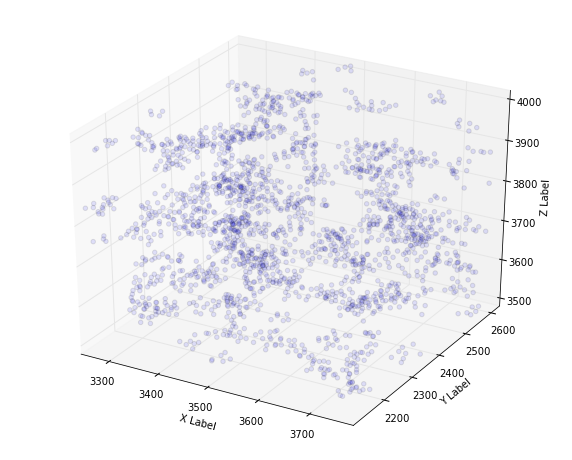

In [300]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
    
ax.scatter(valid_synapse.iloc[:, 2],
           valid_synapse.iloc[:, 3],
           valid_synapse.iloc[:, 4], marker='o', label=valid_synapse.iloc[:,5], alpha=0.1)    
  
ax.set_zlim(zmin, zmax)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
slc = (slice(3490, 4010), slice(2103, 2623), slice(3253, 3773))

In [152]:
z_min = df_coord.loc[:, 'z_start']
z_max = df_coord.loc[:, 'z_start'] + 32
y_min = df_coord.loc[:, 'y_start']
y_max = df_coord.loc[:, 'y_start'] + 32
x_min = df_coord.loc[:, 'x0_start']
x_max = df_coord.loc[:, 'x1_start'] + 32

tbar_invalid = []
tbar_valid = []

for i in range(len(tbar_df)):
    
    x, y, z = tbar_df.values[i, 2:5]

    test = df_coord[(z_min <= z) & (z_max >= z) & (y_min <= y) & (y_max >= y) & (x_min <= x) & (x_max >= x)]

    if i % 10000 == 0:
        print('Progress in {} th tbar'.format(i))
    
    if test.empty :
        tbar_invalid.append(i)
    else:
        tbar_valid.append(i)

print(str(len(tbar_valid)) + ' tbars are inside of roi')

Progress in 0 th tbar
Progress in 10000 th tbar
Progress in 20000 th tbar
Progress in 30000 th tbar
Progress in 40000 th tbar
Progress in 50000 th tbar
31560 tbars are inside of roi


In [153]:
tbar_df.iloc[tbar_valid]

,data,T-bar body ID,T-bar loc (x),T-bar loc (y),T-bar loc (z)
1345,1345,446633,2080,2823,7100
1346,1346,446633,2080,2840,7100
1348,1348,546193,2080,3059,6767
1350,1350,4544,2081,2547,6810
1351,1351,13015,2081,2660,6655
1352,1352,544769,2081,2786,7298
1353,1353,494032,2081,2973,6313
1354,1354,406765,2081,3015,6680
1355,1355,45354,2081,3219,6686
1356,1356,446633,2081,3398,6731


In [155]:
partner_invalid = []
partner_valid = []

for i in range(len(partner_df)):
    
    x, y, z = partner_df.values[i, 2:5]

    test = df_coord[(z_min <= z) & (z_max >= z) & (y_min <= y) & (y_max >= y) & (x_min <= x) & (x_max >= x)]

    if i % 10000 == 0:
        print('Progress in {} th partner'.format(i))

    if test.empty :
        partner_invalid.append(i)
    else:
        partner_valid.append(i)
        
print(str(len(partner_valid)) + ' partners are inside of roi')
        

Progress in 0 th partner
Progress in 10000 th partner
Progress in 20000 th partner
Progress in 30000 th partner
Progress in 40000 th partner
Progress in 50000 th partner
Progress in 60000 th partner
Progress in 70000 th partner
Progress in 80000 th partner
Progress in 90000 th partner
Progress in 100000 th partner
Progress in 110000 th partner
Progress in 120000 th partner
Progress in 130000 th partner
Progress in 140000 th partner
Progress in 150000 th partner
Progress in 160000 th partner
Progress in 170000 th partner
Progress in 180000 th partner
Progress in 190000 th partner
Progress in 200000 th partner
Progress in 210000 th partner
Progress in 220000 th partner
Progress in 230000 th partner
Progress in 240000 th partner
Progress in 250000 th partner
Progress in 260000 th partner
Progress in 270000 th partner
Progress in 280000 th partner
Progress in 290000 th partner
Progress in 300000 th partner
Progress in 310000 th partner
189084 partners are inside of roi


In [278]:
# Merge tbar_df and partner_df via 'outer' join:

synapse_df = tbar_df.iloc[tbar_valid].merge(partner_df.iloc[partner_valid], on='data', how='inner')

print('The DataFrame of synapse_df would have ' + str(len(synapse_df)) + ' of rows')
synapse_df.tail(5)


NameError: name 'tbar_valid' is not defined

In [277]:
tx = synapse_df.iloc[:, 2]
ty = synapse_df.iloc[:, 3]
tz = synapse_df.iloc[:, 4]
px = synapse_df.iloc[:, 6]
py = synapse_df.iloc[:, 7]
pz = synapse_df.iloc[:, 8]

synapse_df['distance'] = np.sqrt(abs(px - tx)**2 + abs(py - ty)**2 + abs(pz - tz)**2)

synapse_df.to_csv('synapse.csv')
synapse_df.tail(5)


NameError: name 'synapse_df' is not defined

In [519]:
synapse_grouped_mean = synapse_.groupby(['data'], sort=True).agg(np.mean).iloc[:, 1:4]
synapse_grouped_std = synapse_.groupby(['data'], sort=True).agg(np.std).iloc[:, 1:4]
synapse_grouped_mean = synapse_grouped_mean.astype(int)
synapse_grouped_mean


,loc (x),loc (y),loc (z)
data,,,
1345,2089,2812,7099
1346,2090,2860,7098
1348,2090,3049,6768
1350,2090,2535,6811
1351,2083,2667,6651
1353,2086,2961,6300
1354,2088,3007,6678
1355,2083,3234,6690
1356,2089,3401,6734


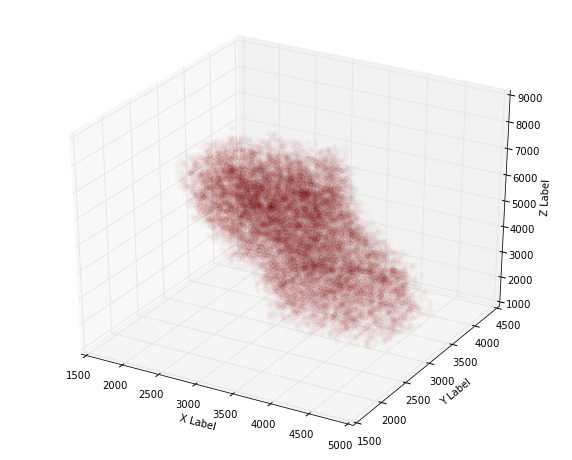

In [516]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
    
ax.scatter(synapse_grouped_mean.iloc[:, 0],
           synapse_grouped_mean.iloc[:, 1],
           synapse_grouped_mean.iloc[:, 2], c='r', marker='o', alpha=0.01)    
  

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [492]:
x, y, z = synapse_grouped_mean.iloc[30000]

image = grayscale[slice(z-24, z+25), slice(y-24, y+25), slice(x-24, x+25)] 
mask = groundtruth[slice(z-24, z+25), slice(y-24, y+25), slice(x-24, x+25)]


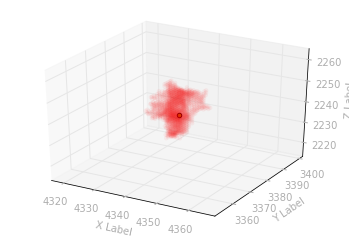

In [499]:
mz, my, mx = np.where(mask == mask[24, 24, 24])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(mx+x-24, my+y-24, mz+z-24, c='r', lw=0, marker='o', alpha=0.05)
ax.scatter(x, y, z, c='y', marker='o')

ax.set_zlim(z-25, z+25)
ax.set_ylim(y-25, y+25)
ax.set_xlim(x-25, x+25)

ax.tick_params(colors='#adadad')
ax.set_xlabel('X Label').set_color("#adadad")
ax.set_ylabel('Y Label').set_color("#adadad")
ax.set_zlabel('Z Label').set_color("#adadad")

plt.savefig('./mask_47624.png', transparent=True)

plt.show()
    


In [500]:
fraction = (float(np.where(mask == mask[24, 24, 24], 1, 0).sum())) / float(len(mask.flatten()))
fraction


0.011636308000917984

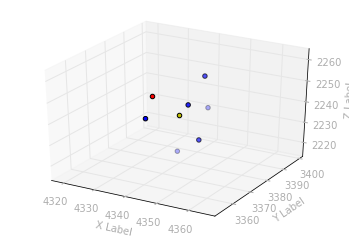

In [502]:
synapse_ = synapse_df[synapse_df['data']==47624]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = synapse_.values[0, 2:5]
px = []
py = []
pz = []

for i in range(len(synapse_)):
    p_x, p_y, p_z = synapse_.iloc[i, 6:9]
    
    px.append(p_x)
    py.append(p_y)
    pz.append(p_z)

mid_x, mid_y, mid_z = (int(sum([x] + px) / (len(synapse_)+1)),
                       int(sum([y] + py) / (len(synapse_)+1)),
                       int(sum([z] + pz) / (len(synapse_)+1)))    
    
ax.scatter(x, y, z, c='r', marker='o')    
ax.scatter(px, py, pz, c='b', marker='o')
ax.scatter(mid_x, mid_y, mid_z, c='y', marker='o')

ax.set_zlim(mid_z-25, mid_z+25)
ax.set_ylim(mid_y-25, mid_y+25)
ax.set_xlim(mid_x-25, mid_x+25)

ax.tick_params(colors='#adadad')
ax.set_xlabel('X Label').set_color("#adadad")
ax.set_ylabel('Y Label').set_color("#adadad")
ax.set_zlabel('Z Label').set_color("#adadad")

plt.savefig('./synapse_47624.png', transparent=True)

plt.show()


In [467]:
import numpy as np
from scipy import ndimage
import skimage
import skimage.feature


In [490]:
edges = ndimage.generic_gradient_magnitude(
    image.astype(np.float32), ndimage.sobel)

sigma = 49.0 / 6.0
thresh_image = np.zeros(edges.shape, dtype=np.float32)
ndimage.gaussian_filter(edges, sigma, output=thresh_image, mode='reflect')
filt_edges = edges > thresh_image

filt_edges[np.where(mask != mask[25, 25, 25])] = 1

dt = ndimage.distance_transform_edt(1 - filt_edges).astype(np.float32)

state = np.random.get_state()
np.random.seed(42)
idxs = skimage.feature.peak_local_max(
    dt + np.random.random(dt.shape) * 1e-4,
    indices=True, min_distance=3, threshold_abs=0, threshold_rel=0)
np.random.set_state(state)

idxs[:, 0] = idxs[:, 0] + z-24
idxs[:, 1] = idxs[:, 1] + y-24
idxs[:, 2] = idxs[:, 2] + x-24
idxs

array([[2260, 3391, 4335],
       [2260, 3381, 4346],
       [2260, 3367, 4348],
       [2260, 3363, 4347],
       [2260, 3359, 4350],
       [2259, 3396, 4350],
       [2259, 3395, 4332],
       [2259, 3378, 4324],
       [2259, 3377, 4329],
       [2259, 3363, 4352],
       [2258, 3394, 4322],
       [2258, 3391, 4331],
       [2258, 3385, 4341],
       [2258, 3370, 4335],
       [2258, 3365, 4321],
       [2258, 3358, 4335],
       [2257, 3387, 4336],
       [2257, 3385, 4323],
       [2257, 3384, 4350],
       [2257, 3383, 4327],
       [2257, 3377, 4336],
       [2257, 3372, 4328],
       [2257, 3361, 4358],
       [2256, 3391, 4347],
       [2256, 3389, 4354],
       [2256, 3373, 4360],
       [2256, 3362, 4362],
       [2256, 3362, 4326],
       [2255, 3379, 4321],
       [2255, 3365, 4348],
       [2254, 3395, 4355],
       [2254, 3390, 4359],
       [2254, 3382, 4363],
       [2254, 3361, 4330],
       [2253, 3391, 4335],
       [2253, 3391, 4330],
       [2253, 3388, 4343],
 

# Find same region from the medulla7column

In [8]:
df_coord.head(5)

,z_start,y_start,x0_start,x1_start
0,1696,2464,3232,4768
1,1696,2496,3232,4768
2,1696,2528,3232,4768
3,1696,2560,3232,4768
4,1696,2592,3232,4768


# Coordinates of validation_sample

(slice(3490, 4010), slice(2103, 2623), slice(3253, 3773))

In [271]:
import h5py 

input_volume = 'third_party/neuroproof_examples/validation_sample/grayscale_maps.h5:raw'
path, dataset = input_volume.split(':')

slc = (slice(3490, 4010), slice(2103, 2623), slice(3253, 3773))

raw = grayscale[slc] 

In [189]:
raw.shape

(1, 520, 520)

(520, 520, 520)


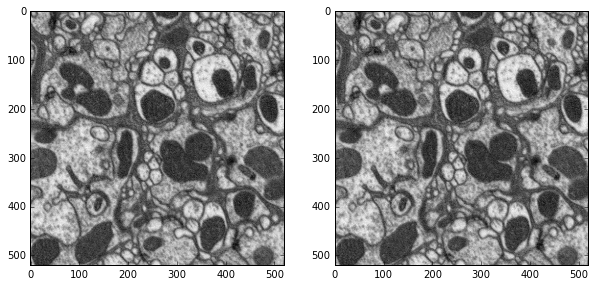

In [274]:
with h5py.File(path) as f:
    gray_maps = f[dataset]
    print(gray_maps.shape)
    gray = gray_maps[519, :520, :520]
    plt.figure(figsize=(10, 20))
    plt.subplot(121)
    plt.imshow(raw[519, :520, :520], cmap='gray')
    plt.subplot(122)
    plt.imshow(gray[:520, :520], cmap='gray')
    plt.show()

In [275]:
synapse_

NameError: name 'synapse_' is not defined